In [66]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import osr
import ogr

In [31]:
iFol = 'xtrak/data/'
iSat = np.array(os.listdir(iFol))
xL = np.array([len(x) for x in iSat])
iSat = iSat[xL>30]

In [40]:
dfZach = pd.DataFrame({'lon':np.array([]),'lat':np.array([]),'h':np.array([]),'track':np.array([]),
                'date':np.array([])})

In [46]:
for i in iSat:
    f = h5py.File(iFol+i, 'r')
    dt = pd.to_datetime(i[6:20])
    
    #return columns names
    main_keys = np.array([])
    for key in f.keys():
        main_keys = np.append(main_keys,key)
    
    #groups of pertinant information-
    groups = main_keys[np.core.defchararray.startswith(main_keys,'g')]
    
    for group in groups:
        f1 = f[group]
        lIce = f1['land_ice_segments']
        lon = lIce['longitude'][()]
        lat = lIce['latitude'][()]
        hIce = lIce['h_li'][()]
            
        #plt.plot(lon,lat,'.')
        #plt.plot([-54,-54,-48,-48],[78.5,73,78.5,73],'o')
        #plt.gca().set_aspect('equal',adjustable='box')
        
        nanArg = hIce != hIce.max()
        hIce = hIce[nanArg]
        lon = lon[nanArg]
        lat = lat[nanArg]
        df = pd.DataFrame({'lon':np.array(lon),'lat':np.array(lat),'h':np.array(hIce)})
        df['track'] = group
        df['date'] = dt
        #plt.plot(df['lon'],df['lat'],'.')
        #plt.show()
        dfZach = dfZach.append(df,ignore_index=True)

FigureCanvasNbAgg()

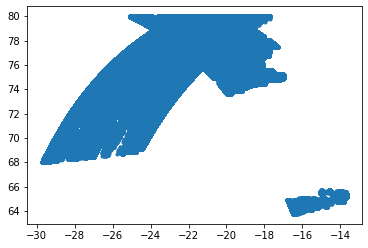

In [48]:
%matplotlib widget
plt.plot(dfZach['lon'],dfZach['lat'],'.')

In [55]:
dfNew =dfZach[np.logical_and(np.logical_and(dfZach['lon']>-22.6,dfZach['lon']<-19.3),np.logical_and(dfZach['lat']>78.7,dfZach['lat']<79.4))]

In [58]:
dfNew.shape
dfNew.columns

Index(['lon', 'lat', 'h', 'track', 'date'], dtype='object')

FigureCanvasNbAgg()

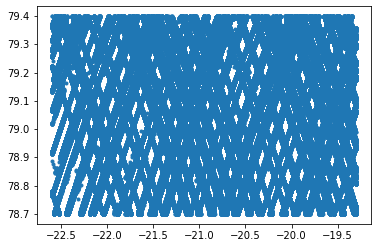

In [57]:
plt.plot(dfNew['lon'],dfNew['lat'],'.')

FigureCanvasNbAgg()

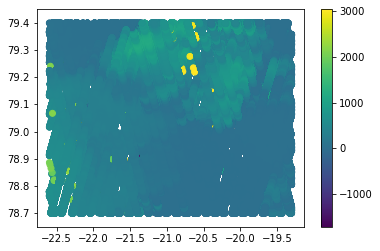

In [60]:
plt.scatter(dfNew['lon'],dfNew['lat'],c=dfNew['h'])
plt.colorbar()

In [64]:
def convertProj(inProj,outProj,xcord,ycord):
    """Variables --
    @inProj: EPSG corrdinate of projection input
    @OutProj: EPSG coordinate of projection output
    @xcord: x coordinates or longitude
    @ycord:y coordinates or latitude
    """
    if inProj == outProj:
        x = xcord
        y =ycord
    else:
        if inProj == 360:
            for ind,x in enumerate(xcord):
                if x > 180:
                    xcord[ind]= x-360
            inProj = 4326
        x = np.zeros(len(xcord))
        y = np.zeros(len(ycord))
        inSR = osr.SpatialReference()
        inSR.ImportFromEPSG(inProj) 
        outSR = osr.SpatialReference()
        outSR.ImportFromEPSG(outProj)
        for ind in np.arange(len(ycord)):
            cPoint = ogr.Geometry(ogr.wkbPoint)
            cPoint.AddPoint(float(xcord[ind]),float(ycord[ind]))
            cPoint.AssignSpatialReference(inSR)
            cPoint.TransformTo(outSR)
            x[ind],y[ind] = cPoint.GetPoint_2D()
    return (x,y)

In [71]:
dfNew['x'],dfNew['y'] = convertProj(4326,3413,dfNew['lon'].values,dfNew['lat'].values)

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
dfNew.columns

Index(['lon', 'lat', 'h', 'track', 'date', 'x', 'y'], dtype='object')

In [73]:
dfNew.shape

(718672, 7)

FigureCanvasNbAgg()

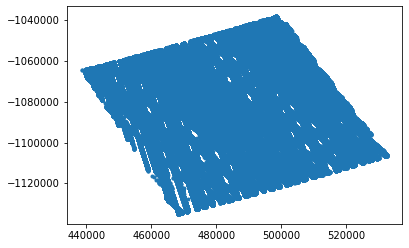

In [74]:
plt.plot(dfNew['x'],dfNew['y'],'.')

In [76]:
dfNew.to_csv('IceSat2ZachData',index=False)